In [202]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [203]:
# Global Variables
# Set the dimensions of the rectangular region
region_width = 100
region_height = 100

# Set the number of demand points
num_demand_points = 20

# Set the coverage radius of a UAV
coverage_radius = 35

# Graph config
figsize=(8,6)


In [204]:
# Create an empty graph
G = nx.Graph()

# Generate random positions for demand points within the rectangular region
demand_points = []
for i in range(num_demand_points):
    x = random.randint(0, region_width)
    y = random.randint(0, region_height)
    demand_points.append((x, y))
    G.add_node(i, pos=(x, y)) 

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 20 nodes and 0 edges


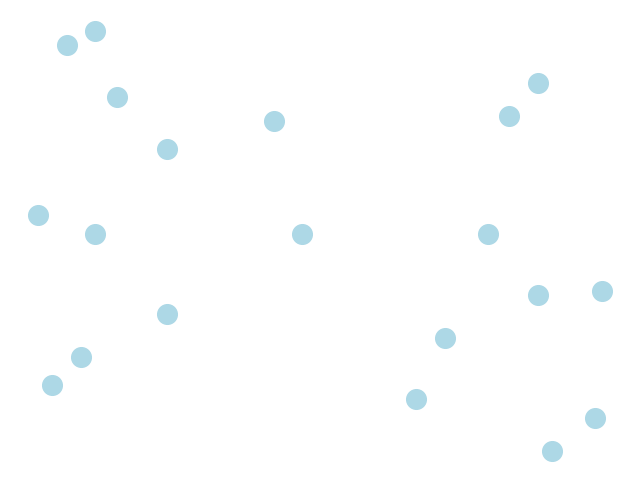

In [205]:
pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=figsize)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)
nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.show()

In [206]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Create a Gurobi model
model = gb.Model()

# Create decision variables
x = {}
for node in G.nodes():
    x[node] = model.addVar(vtype=gb.GRB.BINARY, name=f"x_{node}")


# # Set objective function
model.setObjective(gb.quicksum(x[node] for node in G.nodes()), gb.GRB.MINIMIZE)
# # model.setObjective(x.sum(), gb.GRB.MINIMIZE)

# Add coverage constraints
for node in G.nodes():
    model.addConstr(gb.quicksum(x[n] for n in G.nodes() if n != node and euclidean_distance(G.nodes[node]['pos'], G.nodes[n]['pos']) <= coverage_radius) >= 1, f"cover_{node}")


# Optimize the model
model.update()
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 20 rows, 20 columns and 106 nonzeros
Model fingerprint: 0xde7706be
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 12 rows and 12 columns
Presolve time: 0.00s
Presolved: 8 rows, 8 columns, 39 nonzeros
Variable types: 0 continuous, 8 integer (8 binary)

Root relaxation: cutoff, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         4.00000    4.00000  0.00%     -    0s

Explo

In [207]:
solution = []
if model.status == gb.GRB.OPTIMAL:
    print("Optimization successful.")
    print("With a radius of {} units, {} UAVs are required to cover all {} demand points.".format(coverage_radius, int(model.objVal), num_demand_points))
    for node in G.nodes():
        if x[node].x > 0.1:
            solution.append(node)
else:
    print("No feasible solution found. Optimization status:", model.status)

Optimization successful.
With a radius of 35 units, 4 UAVs are required to cover all 20 demand points.


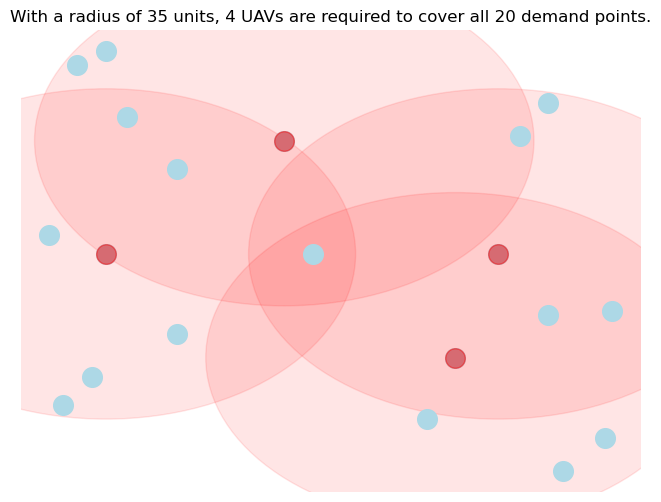

In [208]:
# Create a new graph for visualization
graph_visualization = nx.Graph()

# Add nodes for demand points
for node, demand_point in enumerate(demand_points):
    graph_visualization.add_node(node, pos=demand_point)

# Add edges between demand points covered by the solution
for node in solution:
    graph_visualization.add_edges_from([(node, n) for n in G.neighbors(node) if n in solution])

# Draw the graph
pos = nx.get_node_attributes(graph_visualization, 'pos')
fig, ax = plt.subplots(figsize=figsize)  # Adjust the figure size as desired
nx.draw(graph_visualization, pos, node_color='lightblue', ax=ax, node_size=200)


# Highlight the demand points covered by the solution
nx.draw_networkx_nodes(graph_visualization, pos, nodelist=solution, node_color='r', alpha=0.5, ax=ax, node_size=200)

# Draw circles for coverage radius for covered demand points only
for node in solution:
    if node in graph_visualization.nodes():
        x, y = pos[node]
        circle = plt.Circle((x, y), coverage_radius, alpha=0.1, color='r')
        ax.add_artist(circle)

plt.title("With a radius of {} units, {} UAVs are required to cover all {} demand points.".format(coverage_radius, int(model.objVal), num_demand_points))
plt.show()